In [26]:
#importing libraries

import os
import cv2
from tqdm.notebook import tqdm
import numpy as np
from matplotlib import pyplot as plt
import random

import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras import datasets, layers, models
keras = tf.keras
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [2]:
#reading the dataset
dataset_dir = "./dataset"

print(os.listdir(dataset_dir))
train_classes = os.listdir(dataset_dir + "/train")
print(train_classes)
test_classes = os.listdir(dataset_dir + "/test")
print(test_classes)

['test', 'train']
['Closed', 'no_yawn', 'Open', 'yawn']
['Closed', 'no_yawn', 'Open', 'yawn']


In [50]:
#loading the dataset
#{'Closed': 0, 'no_yawn': 2, 'Open': 1, 'yawn': 3}
dataset_dir = "./dataset"

def load_images(directory):
    images = []
    labels = []

    for category in os.listdir(directory):
        print(category)
        for filename in tqdm(os.listdir(directory+category)):
            image_path = os.path.join(directory,category,filename)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            image = cv2.resize(image,(224,224))
            image = image.astype('float32') / 255.0  # Scale pixel values to [0, 1]
            images.append(image)
            numb = 0
            if(category == 'Open'):
                numb = 1
            elif(category ==  'no_yawn'):
                numb = 2 
            elif(category == 'yawn'):
                numb = 3

            labels.append(numb)

    images = np.array(images,dtype='float32')
    return images, np.array(labels)


#loading dataset
print('*******Loading Train Data*******')
train_ds = load_images(dataset_dir + '/train/' )
print('*******Loading Test Data*******')
test_ds = load_images(dataset_dir + '/test/')

*******Loading Train Data*******
Closed


  0%|          | 0/617 [00:00<?, ?it/s]

no_yawn


  0%|          | 0/616 [00:00<?, ?it/s]

Open


  0%|          | 0/617 [00:00<?, ?it/s]

yawn


  0%|          | 0/617 [00:00<?, ?it/s]

*******Loading Test Data*******
Closed


  0%|          | 0/109 [00:00<?, ?it/s]

no_yawn


  0%|          | 0/109 [00:00<?, ?it/s]

Open


  0%|          | 0/109 [00:00<?, ?it/s]

yawn


  0%|          | 0/106 [00:00<?, ?it/s]

In [44]:
#displaying images function
def display_images_with_labels(images, labels, prediction):
    
    fig, axs = plt.subplots(5, 8, figsize=(15, 10))
    fig.suptitle('Images and Labels')
    for i in range(40):
        axs[i // 8, i % 8].imshow(images[i])
        axs[i // 8, i % 8].axis('off')
        if(prediction):
            axs[i // 8, i % 8].set_title(np.argmax(labels[i]))
        else:
            axs[i // 8, i % 8].set_title(labels[i])
    plt.show()

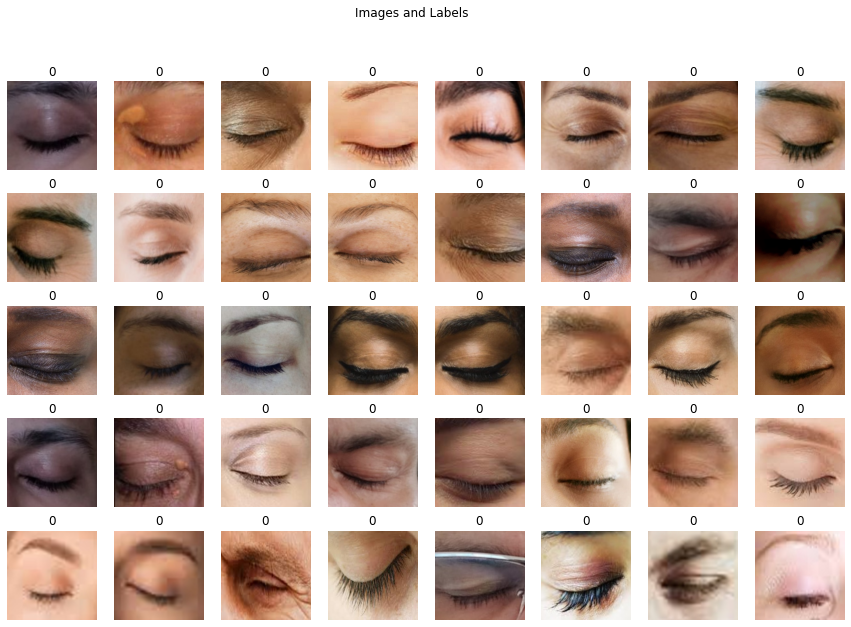

In [34]:
#showing the dataset

display_images_with_labels(train_ds[0], train_ds[1], False)

In [19]:
def display_random_images_with_labels(images, labels):
    """
        Display 40 random images and their labels from the input arrays.
    """
    # Choose 40 random images
    indices = random.sample(range(len(images)), 40)
    random_images = [images[i] for i in indices]
    random_labels = [labels[i] for i in indices]
    
    fig, axs = plt.subplots(5, 8, figsize=(15, 10))
    fig.suptitle('Random Images and Labels')
    for i, (image, label) in enumerate(zip(random_images, random_labels)):
        axs[i // 8, i % 8].imshow(image)
        axs[i // 8, i % 8].axis('off')
        axs[i // 8, i % 8].set_title(label)
    plt.show()

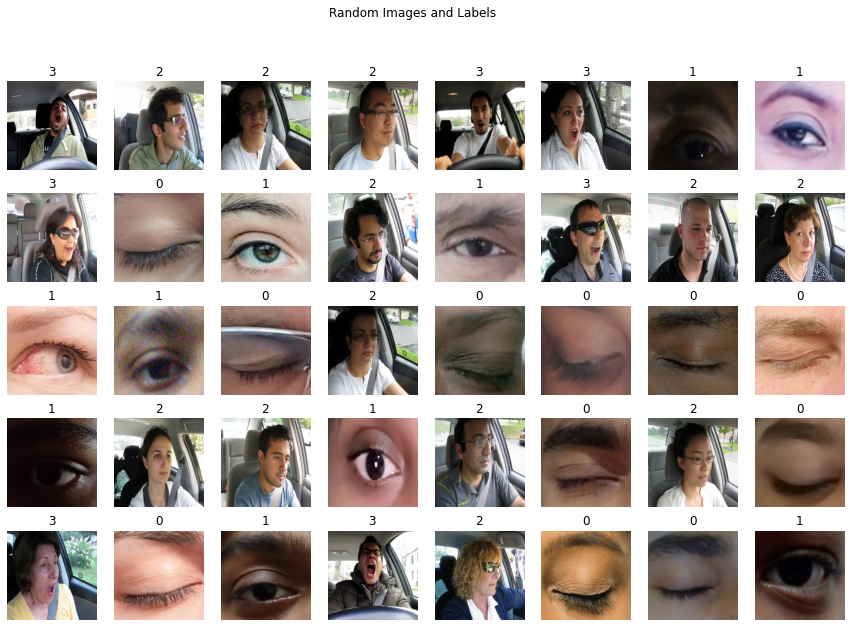

In [35]:
display_random_images_with_labels(train_ds[0], train_ds[1])

In [45]:
# izdelava modela 

model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(4, activation=None))

In [46]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
#label encoding for y_train and y_test
x_train,y_train = train_ds
x_test,y_test =  test_ds

encoder = LabelEncoder()
y_train_ = encoder.fit_transform(y_train)
ytrain_map = dict(zip(y_train, y_train_))  # get the mapping between the original labels and encoded labels
y_test_ = encoder.transform(y_test)
ytest_map =  dict(zip(y_test, y_test_))  # get the mapping between the original labels and encoded labels
y_train = to_categorical(y_train_)
y_test = to_categorical(y_test_)

ytrain_map



{'Closed': 0, 'no_yawn': 2, 'Open': 1, 'yawn': 3}

In [28]:
ytest_map

{'Closed': 0, 'no_yawn': 2, 'Open': 1, 'yawn': 3}

In [51]:
x_train,y_train = train_ds
x_test,y_test =  test_ds
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))#print(y_test[0])
print(x_train.shape)
print(y_train.shape)
# izvedba ucenja 

history = model.fit(x_train, y_train, epochs=8,
                    validation_data=(x_test, y_test))

2467
2467
433
433
(2467, 224, 224, 3)
(2467,)
Epoch 1/8
78/78 [==============================] - 43s 529ms/step - loss: 0.9287 - accuracy: 0.6627 - val_loss: 0.3921 - val_accuracy: 0.8245
Epoch 2/8
78/78 [==============================] - 41s 527ms/step - loss: 0.3093 - accuracy: 0.8618 - val_loss: 0.2697 - val_accuracy: 0.8822
Epoch 3/8
78/78 [==============================] - 42s 539ms/step - loss: 0.1942 - accuracy: 0.9274 - val_loss: 0.2191 - val_accuracy: 0.9053
Epoch 4/8
78/78 [==============================] - 43s 550ms/step - loss: 0.1493 - accuracy: 0.9457 - val_loss: 0.1950 - val_accuracy: 0.9192
Epoch 5/8
78/78 [==============================] - 42s 536ms/step - loss: 0.0882 - accuracy: 0.9704 - val_loss: 0.1567 - val_accuracy: 0.9400
Epoch 6/8
78/78 [==============================] - 42s 532ms/step - loss: 0.0631 - accuracy: 0.9781 - val_loss: 0.2233 - val_accuracy: 0.9330
Epoch 7/8
78/78 [==============================] - 41s 528ms/step - loss: 0.0660 - accuracy: 0.9765 - 

In [52]:
def chart(history):

    plt.figure(figsize=(20,10))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

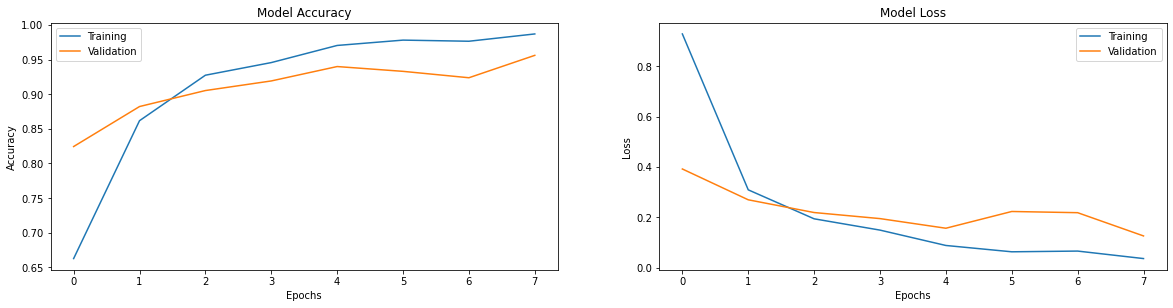

In [53]:
chart(history)